# Dataset

[PyTorch](https://pytorch.org)'s [`torch.utils.data.Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) provides a clean, simple, and standard interface to arbitrary data, which can be combined with [`torch.utils.data.DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for parallel processing.

In [49]:
%load_ext autoreload
%autoreload 2
    
import sys
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

project_root = Path().absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

%matplotlib ipympl

from torch.utils.data import DataLoader
from pyeval import GlobDataset, GzipPickleDataset, TransformDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### `GlobDataset`

A glob is a path pattern which uses, e.g., wildcards `"*"`, to match multiple file paths.

In [5]:
dataset = GlobDataset('/tmp/AA_*/*.gz')

In [6]:
len(dataset)

767

In [7]:
dataset[0]

'/tmp/AA_clock_spect_0G/333.0_Orca_1000.gz'

### `GzipPickleDataset`

`GzipPickleDataset` extends `GlobDataset` to open, decompress and unpickle the files matched via the glob pattern.

In [8]:
dataset = GzipPickleDataset('/tmp/AA_*')

In [9]:
len(dataset)

767

In [10]:
dataset[0]

{'image': array([[[195, 195, 200, ..., 200, 196, 202],
         [201, 203, 224, ..., 199, 209, 204],
         [198, 198, 196, ..., 200, 201, 197],
         ...,
         [198, 196, 201, ..., 213, 198, 196],
         [213, 202, 201, ..., 197, 198, 192],
         [197, 203, 209, ..., 202, 198, 217]],
 
        [[206, 198, 197, ..., 194, 202, 202],
         [202, 206, 224, ..., 200, 201, 197],
         [203, 195, 202, ..., 206, 191, 201],
         ...,
         [215, 199, 200, ..., 193, 199, 201],
         [203, 204, 202, ..., 199, 202, 203],
         [203, 196, 199, ..., 197, 203, 203]]], dtype=uint16),
 'im_num': 420,
 'run': 1164.0,
 'TC_systime_sec': 60653869809016.0,
 'f_blue_big_sideband': 478.0,
 'f_blue_IMG_AOM': 394.16,
 'f_2DMOT_AOM': 354.0,
 'amp_2DMOT_AOM': 0.74,
 'f_xSlower_AOM': 304.0,
 'f_ZS_AOM': 115.0,
 'amp_ZS_AOM': 1.0,
 'f_green_big_sideband': 481.75,
 'f_vexlum_Ref': 121.0,
 'f_vexlum_AOM_op': 80.0,
 'f_vexlum_AOM_raman': 80.0,
 'wavemeter_ch1': 1.0,
 'wavemeter_ch2':

You can also apply a `transform` to your `dataset`

In [11]:
dataset = GzipPickleDataset('/tmp/AA_*', transform=lambda item: item["image"])

In [41]:
image = dataset[1]
image.shape

(2, 50, 320)

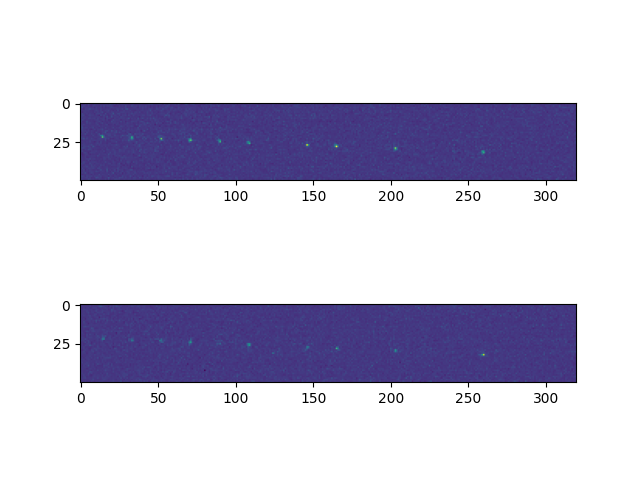

In [48]:
fig, axes = plt.subplots(image.shape[0])

vmin = image.min()
vmax = image.max()

for i in range(image.shape[0]):
    axes[i].imshow(image[i], vmin=vmin, vmax=vmax)

plt.show()

### `DataLoader`

Here we illustrate parallel processing via the pytorch's `DataLoader`.

Let us first compare with the `Dataset` only approach:

In [13]:
%%time

for item_index, images in enumerate(dataset):
    if item_index % 10 == 0:
        print(item_index, images.shape)

0 (2, 50, 320)
10 (2, 50, 320)
20 (2, 50, 320)
30 (2, 50, 320)
40 (2, 50, 320)
50 (2, 50, 320)
60 (2, 50, 320)
70 (2, 50, 320)
80 (2, 50, 320)
90 (2, 50, 320)
100 (2, 50, 320)
110 (2, 50, 320)
120 (2, 50, 320)
130 (2, 50, 320)
140 (2, 50, 320)
150 (2, 50, 320)
160 (2, 50, 320)
170 (2, 50, 320)
180 (2, 50, 320)
190 (2, 50, 320)
200 (2, 50, 320)
210 (2, 50, 320)
220 (2, 50, 320)
230 (2, 50, 320)
240 (2, 50, 320)
250 (2, 50, 320)
260 (2, 50, 320)
270 (2, 50, 320)
280 (2, 50, 320)
290 (2, 50, 320)
300 (2, 50, 320)
310 (2, 50, 320)
320 (2, 50, 320)
330 (2, 50, 320)
340 (2, 50, 320)
350 (2, 50, 320)
360 (2, 50, 320)
370 (2, 50, 320)
380 (2, 50, 320)
390 (2, 50, 320)
400 (2, 50, 320)
410 (2, 50, 320)
420 (2, 50, 320)
430 (2, 50, 320)
440 (2, 50, 320)
450 (2, 50, 320)
460 (2, 50, 320)
470 (2, 50, 320)
480 (2, 50, 320)
490 (2, 50, 320)
500 (2, 50, 320)
510 (2, 50, 320)
520 (2, 50, 320)
530 (2, 50, 320)
540 (2, 50, 320)
550 (2, 50, 320)
560 (2, 50, 320)
570 (2, 50, 320)
580 (2, 50, 320)
590 (2, 

Now we go with batches and two workers:

(the below will fail because we used `transform=lambda x: x["image"]` in jupyter and not in a python file)

In [15]:
parallel_loader = DataLoader(dataset, batch_size=10, num_workers=2, shuffle=False)

In [16]:
%%time

for batch, images in enumerate(parallel_loader):
    print(batch, images.numpy().shape)

CPU times: user 2.63 ms, sys: 14.9 ms, total: 17.5 ms
Wall time: 32.7 ms


PicklingError: Can't pickle <function <lambda> at 0x120c36520>: attribute lookup <lambda> on __main__ failed

As we can see there is quite some time involved in starting and stopping the worker threads. To prove this let us check the case with zero workers:

In [55]:
batch_loader = DataLoader(image_only_dataset, batch_size=10, num_workers=0, shuffle=False)

In [56]:
%%time

for batch, images in enumerate(batch_loader):
    print(batch, images.numpy().shape)

0 (10, 2, 50, 320)
1 (10, 2, 50, 320)
2 (10, 2, 50, 320)
3 (10, 2, 50, 320)
4 (10, 2, 50, 320)
5 (10, 2, 50, 320)
6 (10, 2, 50, 320)
7 (10, 2, 50, 320)
8 (10, 2, 50, 320)
9 (10, 2, 50, 320)
10 (10, 2, 50, 320)
11 (10, 2, 50, 320)
12 (10, 2, 50, 320)
13 (10, 2, 50, 320)
14 (10, 2, 50, 320)
15 (10, 2, 50, 320)
16 (10, 2, 50, 320)
17 (10, 2, 50, 320)
18 (10, 2, 50, 320)
19 (10, 2, 50, 320)
20 (10, 2, 50, 320)
21 (10, 2, 50, 320)
22 (10, 2, 50, 320)
23 (10, 2, 50, 320)
24 (10, 2, 50, 320)
25 (10, 2, 50, 320)
26 (10, 2, 50, 320)
27 (10, 2, 50, 320)
28 (10, 2, 50, 320)
29 (10, 2, 50, 320)
30 (10, 2, 50, 320)
31 (10, 2, 50, 320)
32 (10, 2, 50, 320)
33 (10, 2, 50, 320)
34 (10, 2, 50, 320)
35 (10, 2, 50, 320)
36 (10, 2, 50, 320)
37 (10, 2, 50, 320)
38 (10, 2, 50, 320)
39 (10, 2, 50, 320)
40 (10, 2, 50, 320)
41 (10, 2, 50, 320)
42 (10, 2, 50, 320)
43 (10, 2, 50, 320)
44 (10, 2, 50, 320)
45 (10, 2, 50, 320)
46 (10, 2, 50, 320)
47 (10, 2, 50, 320)
48 (10, 2, 50, 320)
49 (10, 2, 50, 320)
50 (10, 2,

Indeed, we are close to the `Dataset` only approach.